# XFeat matching example using torch hub


## Initialize XFeat

In [9]:
import numpy as np
import imageio as imio
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

!pip install kornia kornia-rs --no-deps # REQUIRED for Lightglue matching

xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 4096)

#Load some example images
im1 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/ref.png')[..., ::-1])
im2 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/tgt.png')[..., ::-1])

Using cache found in /root/.cache/torch/hub/verlab_accelerated_features_main


## Simple function that fits an homography in a set of matches and draw the homography transform

In [10]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    print('inlier ratio: ', np.sum(mask)/len(mask))

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


## Matching example - LightGlue

match features cause time:  4.7767133712768555
inlier ratio:  0.9575835475578406


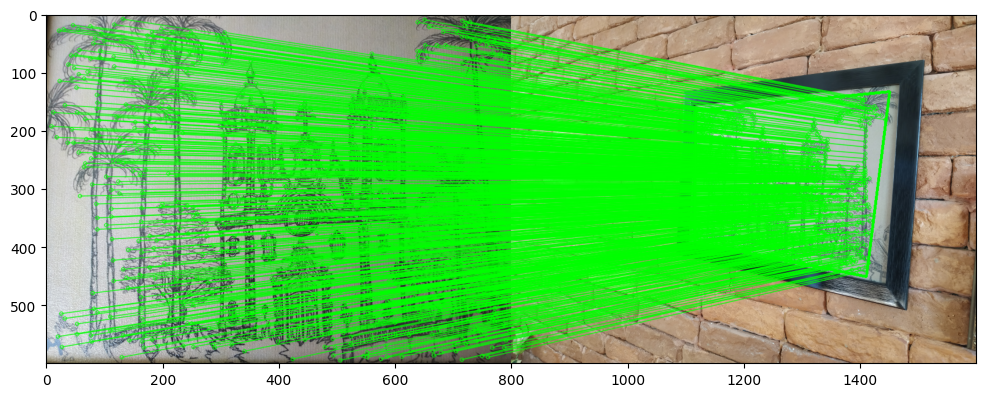

(<matplotlib.image.AxesImage at 0x79deb83df110>, None)

In [13]:
import time

# Inference with batch = 1
output0 = xfeat.detectAndCompute(im1, top_k = 4096)[0]
output1 = xfeat.detectAndCompute(im2, top_k = 4096)[0]

#Update with image resolution (required)
output0.update({'image_size': (im1.shape[1], im1.shape[0])})
output1.update({'image_size': (im2.shape[1], im2.shape[0])})

time_start = time.time()
outputs = xfeat.match_lighterglue(output0, output1)
time_end = time.time()
print("match features cause time: ", time_end - time_start)

mkpts_0 = outputs[0]
mkpts_1 = outputs[1]

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()